### Whole-brain model 

In [1]:
import os
import sys

sys.path.insert(1, os.path.expanduser("~/projects/phase_amplitude_encoding"))

In [2]:
import jax
import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray as xr
from frites.core import copnorm_nd
from hoi.core import get_mi
from mne.time_frequency import psd_array_multitaper
from mne.time_frequency.tfr import tfr_array_morlet, tfr_array_multitaper
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

from src.models import simulate, simulate_delayed

/opt/anaconda3/envs/test_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
jax.config.update("jax_platform_name", "cpu")

### Functions

In [4]:
def digitize_equiprobable(data, N):
    """
    Coarse-grain continuous data into N equiprobable bins (quantile-based).
    Each sample is replaced by the bin's representative (mean) value.

    Parameters:
        data (array-like): input float data (any shape)
        N (int): number of bins

    Returns:
        np.ndarray: data replaced by bin representative values
        np.ndarray: bin edges used
    """
    data = np.asarray(data)

    # Compute quantile-based bin edges
    quantiles = np.linspace(0, 1, N + 1)
    bin_edges = np.quantile(data, quantiles)

    # Digitize using those edges
    bin_idx = np.digitize(data, bin_edges, right=False)
    bin_idx = np.clip(bin_idx, 0, N - 1)

    # Compute representative (mean or center) value per bin
    bin_values = []
    for i in range(N):
        # Values that fall into this bin
        vals_in_bin = data[(data >= bin_edges[i]) & (data < bin_edges[i+1])]
        if len(vals_in_bin) > 0:
            # Use bin mean
            bin_values.append(np.mean(vals_in_bin))
        else:
            # Fallback: midpoint of bin edges
            bin_values.append(0.5 * (bin_edges[i] + bin_edges[i+1]))
    bin_values = np.array(bin_values)

    # Replace each value with its bin's representative
    coarse_data = bin_values[bin_idx]

    return bin_idx

#### Load anatomical data

In [5]:
area_names = [
    "V1",
    "V2",
    "V4",
    "DP",
    "MT",
    "8m",
    "5",
    "8l",
    "TEO",
    "2",
    "F1",
    "STPc",
    "7A",
    "46d",
    "10",
    "9/46v",
    "9/46d",
    "F5",
    "TEpd",
    "PBr",
    "7m",
    "7B",
    "F2",
    "STPi",
    "PROm",
    "F7",
    "8B",
    "STPr",
    "24c",
]

area_names = np.asarray(area_names)

In [6]:
sel_area_names = ["V1", "V2", "V4", "8m", "7A", "9/46d", "24c"]

In [7]:
data = np.load("../interareal/markov2014.npy", allow_pickle=True).item()

# Graph parameters
Nareas = 29  # Number of areas
# FLN matrix
flnMat = data["FLN"]
# Distance matrix
D = data["Distances"] * 1e-3 / 3.5
# Hierarchy values
h = np.squeeze(data["Hierarchy"].T)

eta = 0

#### Simulation parameters

In [8]:
ntrials = 300
dt = 1e-4
fsamp = 1 / dt
time = np.arange(-4, 2, 1 / fsamp)
beta = 1e-4
Npoints = len(time)
decim = 20
f = 10  # np.linspace(20, 60, Nareas)[::-1]  # Node natural frequency in Hz
D = (D / dt).astype(int)
flnMat = (1 + eta * h)[:, np.newaxis] * flnMat

seeds = np.random.randint(0, 10000, ntrials)

In [9]:
s = 8 / (2 * np.pi * f)

time_start = 0
time_end = 0.5
timestim = time[(time > time_start) & (time < time_end)] - (time_end - time_start) / 2
ind = np.where((time > time_start) & (time < time_end))[0]
gaussian = np.exp(-(timestim**2) / (2 * s**2))
coupling = np.zeros_like(time)
coupling = (time > time_start) & (time < time_end)

# Coupling strength array (linearly spaced from 1 to 100)
CS = np.linspace(0, 1e-2, ntrials)
seeds = np.random.randint(0, 100000, ntrials)

In [10]:
coupling = CS[:, None] * coupling

In [11]:
Iext = np.zeros((ntrials, Nareas, len(time)))
Iext[:, 0] = coupling

In [12]:
out = []
for trial in tqdm(range(ntrials)):

    out += [
        simulate(
            flnMat,
            10,  # oupling[trial],
            f,
            -5,
            fsamp,
            1e-4,
            Npoints,
            Iext[trial],
            seeds[trial],
            decim=decim,
            stim_mode="both",
        )
    ]

100%|█████████████████████████████████| 300/300 [01:19<00:00,  3.80it/s]


#### Convert to xarray

In [13]:
data = xr.DataArray(
    np.stack(out),
    dims=("trials", "roi", "times"),
    coords=(range(ntrials), area_names, time[::decim]),
).sel(times=slice(-2, 2))

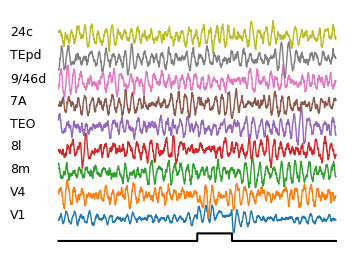

In [14]:
plt.figure(figsize=(10 / 2.54, 8 / 2.54))
ax = plt.subplot(111)
z_data = (data - data.mean("times")) / data.std("times")
for i, roi in enumerate(["V1", "V4", "8m", "8l", "TEO", "7A", "9/46d", "TEpd", "24c"]):
    plt.plot(z_data[-1].times, z_data[-1].values[i].real + (i * 3), lw=1)
    plt.text(-2.7, i * 3, roi, fontsize=9)
mask = (time >= -2) * (time <= 2)
plt.plot(time[mask], (Iext[-1, 0, mask] * 100 - 3), "k")
plt.axis("off")

plt.savefig("figures/wbm_time_series.png", bbox_inches="tight")

In [15]:
labels = np.tile(np.expand_dims(CS, 1), data.sizes["times"])

In [16]:
mi_fcn = get_mi("binning")
mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2))

In [17]:
I_S_R1 = []
I_S_R2 = []
I_S_R1_R2 = []
for i in tqdm(range(1, Nareas)):

    z = data.isel(roi=0) * np.conj(data.isel(roi=i))
    A = np.abs(z).values
    dphi = np.unwrap(np.angle(z))

    A = digitize_equiprobable(A, 100)
    dphi = digitize_equiprobable(dphi, 100)
    
    mv = np.stack((A, dphi), axis=0)

    I_S_R1 += [mi_fcn_time(A[None], labels[None])]
    I_S_R2 += [mi_fcn_time(dphi[None], labels[None])]
    I_S_R1_R2 += [mi_fcn_time(mv, labels[None])]

100%|███████████████████████████████████| 28/28 [00:15<00:00,  1.84it/s]


In [18]:
I_S_R1 = np.stack(I_S_R1)
I_S_R2 = np.stack(I_S_R2)
I_S_R1_R2 = np.stack(I_S_R1_R2)

In [19]:
kernel = np.hanning(20)
kernel = kernel / kernel.sum()
kernel = kernel[None]

I_S_R1 = scipy.signal.fftconvolve(I_S_R1, kernel, mode="same", axes=1)
I_S_R2 = scipy.signal.fftconvolve(I_S_R2, kernel, mode="same", axes=1)
I_S_R1_R2 = scipy.signal.fftconvolve(I_S_R1_R2, kernel, mode="same", axes=1)

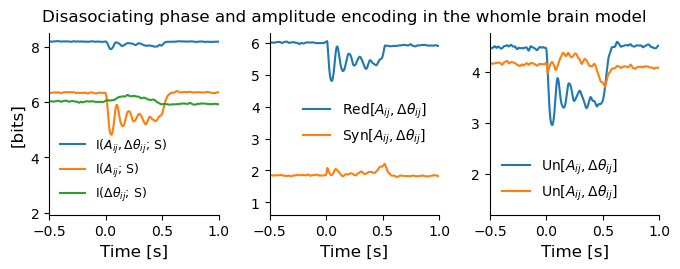

In [20]:
fig = plt.figure(figsize=(20 / 2.54, 6 / 2.54))

ax = plt.subplot(1, 3, 1)

plt.plot(z_data[-1].times, I_S_R1_R2[-1])
plt.plot(z_data[-1].times, I_S_R1[-1])
plt.plot(z_data[-1].times, I_S_R2[-1])

plt.legend(
    [
        r"I($A_{ij}, \Delta\theta_{ij}$; S)",
        r"I($A_{ij}$; S)",
        r"I($\Delta\theta_{ij}$; S)",
    ],
    frameon=False,
    fontsize=9,
)

plt.ylabel("[bits]", fontsize=12)
plt.xlabel("Time [s]", fontsize=12)
plt.xlim(-.5, 1)

[ax.spines[key].set_visible(False) for key in ["top", "right"]]

ax = plt.subplot(1, 3, 2)

red = np.minimum(I_S_R2[-1], I_S_R1[-1])
syn = I_S_R1_R2[-1] - np.maximum(I_S_R2[-1], I_S_R1[-1])

plt.plot(data.times, red)
plt.plot(data.times, syn)

plt.legend(
    [
        r"Red[$A_{ij}, \Delta\theta_{ij}$]",
        r"Syn[$A_{ij}, \Delta\theta_{ij}$]",
    ],
    frameon=False,
)

[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.xlabel("Time [s]", fontsize=12)
plt.xlim(-.5, 1)

ax = plt.subplot(1, 3, 3)

syn = I_S_R1_R2[-1] - np.maximum(I_S_R2[-1], I_S_R1[-1])

plt.plot(data.times, I_S_R1[-1] - syn)
plt.plot(data.times, I_S_R2[-1] - syn)

plt.legend(
    [
        r"Un[$A_{ij}, \Delta\theta_{ij}$]",
        r"Un[$A_{ij}, \Delta\theta_{ij}$]",
    ],
    frameon=False,
)
plt.xlabel("Time [s]", fontsize=12)
plt.xlim(-.5, 1)

[ax.spines[key].set_visible(False) for key in ["top", "right"]]

plt.subplots_adjust(wspace=0.3)
plt.suptitle("Disasociating phase and amplitude encoding in the whomle brain model")

plt.savefig("figures/disasociating.png", bbox_inches="tight")

#### High-oder phase-interactions

In [21]:
from hoi.metrics import RedundancyMMI, SynergyMMI

In [33]:
area_indices = []
for i in range(Nareas):
    if area_names[i] in sel_area_names:
        area_indices.append(i)
nSelAreas = len(area_indices)

In [34]:
edges = []

In [35]:
roi_st = []
dh_ij = []
for i in range(nSelAreas):
    for j in range(i + 1, nSelAreas):
        s, t = area_indices[i], area_indices[j]
        phi = np.unwrap(np.angle(data[:, s] * np.conj(data[:, t])))
        edges += [phi]
        roi_st += [f"{area_names[s]}-{area_names[t]}"]
        dh_ij += [np.abs(h[s] - h[t])]

In [36]:
dh_ij = np.stack(dh_ij)

In [37]:
edges = np.stack(edges, 1)

In [38]:
edges = xr.DataArray(digitize_equiprobable(edges, 1000), dims=data.dims, coords=(data.trials, roi_st, data.times))

In [42]:
model_red = RedundancyMMI(edges, np.arange(ntrials))

model_syn = SynergyMMI(edges, np.arange(ntrials))

In [43]:
red = model_red.fit(minsize=2, maxsize=2, method="binning")

syn = model_syn.fit(minsize=2, maxsize=2, method="binning")

Get list of multiplets
  0%|                                      |  0/1 [00:00<?,       ?it/s]/opt/anaconda3/envs/test_env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
Get list of multiplets                                                  
  0%|                                      |  0/1 [00:00<?,       ?it/s]/opt/anaconda3/envs/test_env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
                                                                        

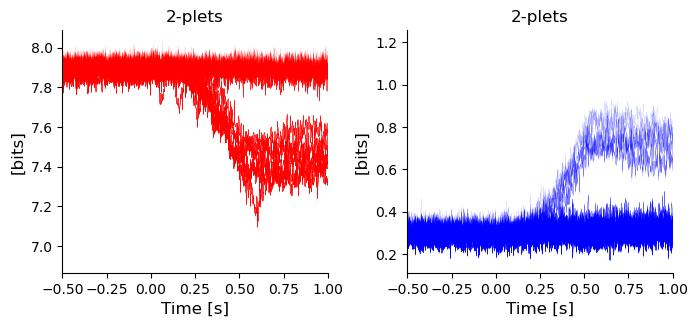

In [47]:
plt.figure(figsize=(20 / 2.54, 8 / 2.54))
ax = plt.subplot(121)
plt.plot(
    data.times,
    red.T,
    "r",
    lw=0.05,
    label=r"Red[$\Delta\theta_{ij}$, $\Delta\theta_{il}$]",
)
plt.legend(frameon=False)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.title("2-plets", fontsize=12)
plt.ylabel("[bits]", fontsize=12)
plt.xlabel("Time [s]", fontsize=12)
ax.get_legend().remove()
plt.xlim(-.5, 1)

ax = plt.subplot(122)

plt.plot(
    data.times,
    syn.T,
    "b",
    lw=0.05,
    label=r"Syn[$\Delta\theta_{ij}$, $\Delta\theta_{il}$]",
)
plt.legend(frameon=False)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.title("2-plets", fontsize=12)
plt.ylabel("[bits]", fontsize=12)
plt.xlabel("Time [s]", fontsize=12)
plt.xlim(-.5, 1)

ax.get_legend().remove()
plt.subplots_adjust(wspace=0.3)

Text(0.5, 1.0, 'Average Red. vs. Syn for 2-plets')

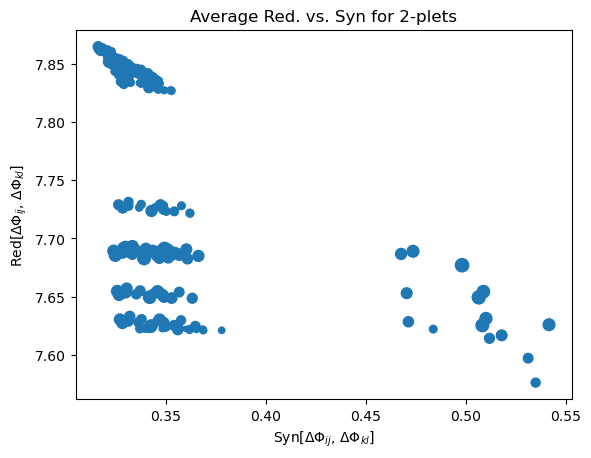

In [45]:
from matplotlib.patches import Rectangle

ax = plt.subplot(111)
plt.scatter(
    np.nanmean(syn, 1), np.nanmean(red, 1), s=dh_ij[model_red.multiplets].mean(1) * 100
)
plt.xlabel(r"Syn[$\Delta\Phi_{ij}$, $\Delta\Phi_{kl}$]")
plt.ylabel(r"Red[$\Delta\Phi_{ij}$, $\Delta\Phi_{kl}$]")

#ax.add_patch(Rectangle((0.0035, 0.04), 0.018, 0.04, fill=False, color="r"))
#ax.add_patch(Rectangle((0.028, -0.0005), 0.008, 0.015, fill=False, color="g"))
plt.title("Average Red. vs. Syn for 2-plets")

In [50]:
indexes = model_red.multiplets[
    np.logical_and(np.nanmean(red, 1) > 0.04, np.nanmean(syn, 1) > 0.0)
]

In [51]:
indexes

array([[0, 1, 2],
       [0, 1, 3],
       [0, 1, 4],
       [0, 1, 5],
       [0, 2, 3],
       [0, 2, 4],
       [0, 2, 5],
       [0, 3, 4],
       [0, 3, 5],
       [0, 4, 5],
       [1, 2, 3],
       [1, 2, 4],
       [1, 2, 5],
       [1, 3, 4],
       [1, 3, 5],
       [1, 4, 5],
       [2, 3, 4],
       [2, 3, 5],
       [2, 4, 5],
       [3, 4, 5]])

In [52]:
for i, j, k in indexes:
    print(f"{roi_st[i]} - {roi_st[j]} - {roi_st[k]}")

V1-V2 - V1-V4 - V1-8m
V1-V2 - V1-V4 - V1-7A
V1-V2 - V1-V4 - V1-9/46d
V1-V2 - V1-V4 - V1-24c
V1-V2 - V1-8m - V1-7A
V1-V2 - V1-8m - V1-9/46d
V1-V2 - V1-8m - V1-24c
V1-V2 - V1-7A - V1-9/46d
V1-V2 - V1-7A - V1-24c
V1-V2 - V1-9/46d - V1-24c
V1-V4 - V1-8m - V1-7A
V1-V4 - V1-8m - V1-9/46d
V1-V4 - V1-8m - V1-24c
V1-V4 - V1-7A - V1-9/46d
V1-V4 - V1-7A - V1-24c
V1-V4 - V1-9/46d - V1-24c
V1-8m - V1-7A - V1-9/46d
V1-8m - V1-7A - V1-24c
V1-8m - V1-9/46d - V1-24c
V1-7A - V1-9/46d - V1-24c


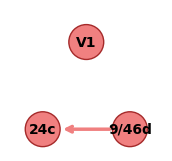

In [233]:
import matplotlib.pyplot as plt
import numpy as np


def draw_three_node_triangle(
    top,
    left,
    right,
    top_left=0,
    left_top=0,
    top_right=0,
    right_top=0,
    left_right=0,
    right_left=0,
    color="lightcoral",
    ec="brown",
):
    """
    Draws a simple 3-node triangle with optional directed edges.
    If an edge value = 0, no arrow is drawn.
    """
    fig, ax = plt.subplots(figsize=(5 / 2.54, 5 / 2.54))

    # Node coordinates (flatter triangle, normalized [0,1])
    top_pos = np.array([0.5, 0.6])
    left_pos = np.array([0.3, 0.2])
    right_pos = np.array([0.7, 0.2])
    coords = {top: top_pos, left: left_pos, right: right_pos}
    r = 0.08  # node radius

    # Draw nodes
    for (x, y), label in [(top_pos, top), (left_pos, left), (right_pos, right)]:
        circle = plt.Circle((x, y), r, color=color, ec=ec, zorder=2)
        ax.add_patch(circle)
        ax.text(
            x,
            y,
            label,
            ha="center",
            va="center",
            fontsize=10,
            fontweight="bold",
            zorder=3,
        )

    def draw_arrow(p1, p2, value, offset=(0, 0)):
        """Draw an arrow p1→p2 with signed float label, if value != 0."""
        if value == 0:
            return
        elif value > 0:
            arrowstyle = "->"
        else:
            arrowstyle = "<-"
        # Vector direction
        v = p2 - p1
        v = v / np.linalg.norm(v)
        # Start/end outside circle
        start = p1 + v * r
        end = p2 - v * r
        # Arrow
        ax.annotate(
            "",
            xy=end,
            xytext=start,
            arrowprops=dict(arrowstyle=arrowstyle, color=color, lw=2.5),
        )

    # Draw all possible edges
    draw_arrow(top_pos, left_pos, top_left, offset=(-0.05, 0))
    draw_arrow(left_pos, top_pos, left_top, offset=(-0.05, 0))
    draw_arrow(top_pos, right_pos, top_right, offset=(0.05, 0))
    draw_arrow(right_pos, top_pos, right_top, offset=(0.05, 0))
    draw_arrow(left_pos, right_pos, left_right, offset=(0, -0.05))
    draw_arrow(right_pos, left_pos, right_left, offset=(0, -0.05))

    # Adjust plot limits
    plt.xlim(0.15, 0.85)
    plt.ylim(0.1, 0.75)
    ax.set_aspect("equal")
    ax.axis("off")
    return fig, ax


# Example usage
area1 = "V1"
area2 = "24c"
area3 = "9/46d"

i, j, k = np.hstack([np.where(area_names == area)[0] for area in [area1, area2, area3]])

# Example edge weights (you can use your flnMat calculations here)
e_top_left = flnMat[j, i] - flnMat[i, j]
e_left_top = 0.0
e_top_right = flnMat[k, i] - flnMat[i, k]
e_right_top = 0.
e_left_right = flnMat[k, j] - flnMat[j, k]
e_right_left = 0.0

fig, ax = draw_three_node_triangle(
    area1,
    area2,
    area3,
    top_left=e_top_left,
    left_top=e_left_top,
    top_right=e_top_right,
    right_top=e_right_top,
    left_right=e_left_right,
    right_left=e_right_left,
    #color="lightgreen",
    #ec="g"
)

plt.savefig("figures/node_example.png", bbox_inches="tight")